<a href="https://colab.research.google.com/github/0sparsh2/Train-Rush-Predictor/blob/main/passenger_travel_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Passengers train rush predictor

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble as ske

from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

import eli5
from eli5.sklearn import PermutationImportance
seed = 12
np.random.seed(seed)


In [145]:
!pip install eli5

     |████████████████████████████████| 106 kB 9.6 MB/s 


##Training Data



In [218]:
df = pd.read_csv('train.csv')
#df.head()

In [219]:
from collections import Counter

#Drop id_code? check how to manage that
#okay yes, need to remove later
#both for training and testing

#Date and Time cylinderical format

#Encode string data to encoded formats for classification, so:
#     destination_name, train_name, 

#Target to 0,1,2 - Need to find it so final label

#Drop year since same for all - DONE

# remove...country code_source ? Since ratio 1:1:1:1280:1, drop it - DONE

#nan in country_code_destination too so remove? or drop it - DONE

#towards end, remove rows with Nan in them - DONE
#df = df[df['column_name'].notna()]


li = list(df['train_name'])
ab = Counter(li)
#ab

###Prepare Data

In [220]:
#Since year same for all
df = df.drop(['current_year'], axis=1)

#Same country code destination and source
df = df.drop(['country_code_destination'], axis=1)
df = df[df['id_code'].notna()]
df = df.drop(['country_code_source'], axis=1)

#remove null columns of longitudal_source 
df = df[df['longitude_source'].notna()]

#remove null columns of latitude_source 
df = df[df['latitude_source'].notna()]

#remove null columns of longitude_destination 
df = df[df['longitude_destination'].notna()]

#remove null columns of latitude_destination 
df = df[df['latitude_destination'].notna()]

#remove id_code column
df = df.drop(['id_code'], axis=1)

#Replace weekend binary
weekend_binary = {True:0,False:1}
df = df.replace({'is_weekend': weekend_binary})



mapping1 = {'low': 1, 'medium': 2, 'high':3}
mapping2 = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5,'Saturday':6,'Sunday':7}

df = df.replace({'target': mapping1, 'current_day': mapping2})



df['current_time'] = (pd.to_datetime(df['current_time'].str.strip(), format='%I:%M:%S %p')
                  .dt.strftime('%H:%M:%S'))

In [221]:
#Cyclic for week
days_in_week = 7
df['sin_day'] = np.sin(2*np.pi*df.current_day/days_in_week)
df['cos_day'] = np.cos(2*np.pi*df.current_day/days_in_week)
df.drop('current_day', axis=1, inplace=True)


#Cyclic for weeks
total_weeks = 54
df['sin_week'] = np.sin(2*np.pi*df.current_week/total_weeks)
df['cos_week'] = np.cos(2*np.pi*df.current_week/total_weeks)
df.drop('current_week', axis=1, inplace=True)


#Cyclic for time
df['current_time'] = (pd.to_timedelta(df['current_time']).dt.total_seconds())
seconds_in_day = 24*60*60
df['sin_time'] = np.sin(2*np.pi*df.current_time/seconds_in_day)
df['cos_time'] = np.cos(2*np.pi*df.current_time/seconds_in_day)
df.drop('current_time', axis=1, inplace=True)

#cyclic for month
df['months'] = (pd.to_datetime(df['current_date']).dt.month)
months_in_year = 12
df['sin_month'] = np.sin(2*np.pi*df.months/months_in_year)
df['cos_month'] = np.cos(2*np.pi*df.months/months_in_year)
df.drop('months', axis=1, inplace=True)

#Cyclic for date
df['date'] = (pd.to_datetime(df['current_date']).dt.day)
dates_in_month = 31
df['sin_date'] = np.sin(2*np.pi*df.date/dates_in_month)
df['cos_date'] = np.cos(2*np.pi*df.date/dates_in_month)
df.drop('date', axis=1, inplace=True)


df.drop('current_date', axis=1, inplace=True)



#source_name and destination_name
df['source_name'] = df['source_name'].str[8:].astype(int)
df['destination_name'] = df['destination_name'].str[8:].astype(int)


'''tl_li = list(df['train_name'] )
tl_dict = {}
for i in range(len(tl_li)):
  tl_dict[tl_li[i]] = i

df = df.replace({'train_name': tl_dict})'''

#Since there's a wide distribution of train names
df.drop('train_name', axis=1, inplace=True)


In [135]:
#df.drop('current_date', axis=1, inplace=True)

In [108]:
#df['date_time'] = df['current_date']+' '+df['current_time']
#df.drop('date_time', axis=1, inplace=True)


In [ ]:
#train_name, destination_name, source_name

In [222]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df[['mean_halt_times_destination', 'latitude_destination','longitude_destination','mean_halt_times_source','latitude_source','longitude_source']] = scaler.fit_transform(df[['mean_halt_times_destination', 'latitude_destination','longitude_destination','mean_halt_times_source','latitude_source','longitude_source']])

In [223]:
y_train = df.pop('target')
X_train = df

In [224]:
df

,source_name,destination_name,longitude_source,latitude_source,mean_halt_times_source,longitude_destination,latitude_destination,mean_halt_times_destination,is_weekend,sin_day,cos_day,sin_week,cos_week,sin_time,cos_time,sin_month,cos_month,sin_date,cos_date
31,130,214,0.734556,0.534061,0.932495,0.626976,0.847436,0.446426,1,0.433884,-0.900969,-0.342020,-0.939693,-0.079474,0.996837,-0.500000,-0.866025,-0.724793,0.688967
32,248,248,0.920669,0.581027,0.057495,0.779875,0.841767,0.057495,1,-0.433884,-0.900969,-0.342020,-0.939693,0.019270,0.999814,-0.500000,-0.866025,-0.571268,0.820763
34,248,147,0.920669,0.581027,0.057495,0.607997,0.828163,0.923610,1,-0.433884,-0.900969,-0.342020,-0.939693,0.079112,0.996866,-0.500000,-0.866025,-0.571268,0.820763
35,177,130,0.754403,0.550152,0.249077,0.608606,0.829733,0.932495,1,-0.433884,-0.900969,-0.342020,-0.939693,0.167056,0.985947,-0.500000,-0.866025,-0.571268,0.820763
36,544,147,0.628116,0.611132,0.450055,0.607997,0.828163,0.923610,1,-0.433884,-0.900969,-0.342020,-0.939693,0.735949,-0.677037,-0.500000,-0.866025,-0.571268,0.820763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,130,279,0.734556,0.534061,0.932495,0.716898,0.817212,0.127449,1,0.433884,-0.900969,-0.998308,-0.058145,-0.743631,-0.668590,-0.866025,0.500000,0.848644,0.528964
1280,544,266,0.628116,0.611132,0.450055,0.662091,0.832267,0.512537,1,0.433884,-0.900969,-0.998308,-0.058145,-0.998013,0.063008,-0.866025,0.500000,0.848644,0.528964
1281,147,159,0.733894,0.527936,0.923610,0.609287,0.805726,0.071179,1,0.433884,-0.900969,-0.998308,-0.058145,-0.994643,0.103371,-0.866025,0.500000,0.848644,0.528964
1282,147,422,0.733894,0.527936,0.923610,0.612112,0.790086,0.148500,1,0.433884,-0.900969,-0.998308,-0.058145,-0.992775,0.119992,-0.866025,0.500000,0.848644,0.528964


##Training Data

In [227]:
df2 = pd.read_csv('test.csv')

#Since year same for all
df2 = df2.drop(['current_year'], axis=1)

#Same country code destination and source
df2 = df2.drop(['country_code_destination'], axis=1)
df2 = df2[df2['id_code'].notna()]
df2 = df2.drop(['country_code_source'], axis=1)

#remove null columns of longitudal_source 
df2 = df2[df2['longitude_source'].notna()]

#remove null columns of latitude_source 
df2 = df2[df2['latitude_source'].notna()]

#remove null columns of longitude_destination 
df2 = df2[df2['longitude_destination'].notna()]

#remove null columns of latitude_destination 
df2 = df2[df2['latitude_destination'].notna()]

#remove id_code column
df2 = df2.drop(['id_code'], axis=1)

#Replace weekend binary
weekend_binary = {True:0,False:1}
df2 = df2.replace({'is_weekend': weekend_binary})




mapping1 = {'low': 1, 'medium': 2, 'high':3}
mapping2 = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5,'Saturday':6,'Sunday':7}

df2 = df2.replace({'target': mapping1, 'current_day': mapping2})

df2['current_time'] = (pd.to_datetime(df2['current_time'].str.strip(), format='%I:%M:%S %p')
                  .dt.strftime('%H:%M:%S'))




#Cyclic for week
days_in_week = 7
df2['sin_day'] = np.sin(2*np.pi*df2.current_day/days_in_week)
df2['cos_day'] = np.cos(2*np.pi*df2.current_day/days_in_week)
df2.drop('current_day', axis=1, inplace=True)


#Cyclic for weeks
total_weeks = 54
df2['sin_week'] = np.sin(2*np.pi*df2.current_week/total_weeks)
df2['cos_week'] = np.cos(2*np.pi*df2.current_week/total_weeks)
df2.drop('current_week', axis=1, inplace=True)


#Cyclic for time
df2['current_time'] = (pd.to_timedelta(df2['current_time']).dt.total_seconds())
seconds_in_day = 24*60*60
df2['sin_time'] = np.sin(2*np.pi*df2.current_time/seconds_in_day)
df2['cos_time'] = np.cos(2*np.pi*df2.current_time/seconds_in_day)
df2.drop('current_time', axis=1, inplace=True)

#cyclic for month
df2['months'] = (pd.to_datetime(df2['current_date']).dt.month)
months_in_year = 12
df2['sin_month'] = np.sin(2*np.pi*df2.months/months_in_year)
df2['cos_month'] = np.cos(2*np.pi*df2.months/months_in_year)
df2.drop('months', axis=1, inplace=True)

#Cyclic for date
df2['date'] = (pd.to_datetime(df2['current_date']).dt.day)
dates_in_month = 31
df2['sin_date'] = np.sin(2*np.pi*df2.date/dates_in_month)
df2['cos_date'] = np.cos(2*np.pi*df2.date/dates_in_month)
df2.drop('date', axis=1, inplace=True)


df2.drop('current_date', axis=1, inplace=True)


df2['source_name'] = df2['source_name'].str[8:].astype(int)
df2['destination_name'] = df2['destination_name'].str[8:].astype(int)


df2[['mean_halt_times_destination', 'latitude_destination','longitude_destination','mean_halt_times_source','latitude_source','longitude_source']] = scaler.fit_transform(df2[['mean_halt_times_destination', 'latitude_destination','longitude_destination','mean_halt_times_source','latitude_source','longitude_source']])

In [228]:
#tl_li2 = list(df2['train_name'] )
#tl_dict = {}
#for i in range(len(tl_li)):
#  tl_dict[tl_li[i]] = i
df2.drop('train_name', axis=1, inplace=True)

In [229]:
#tl_dict

In [231]:
df2.head()

,source_name,destination_name,longitude_source,latitude_source,mean_halt_times_source,longitude_destination,latitude_destination,mean_halt_times_destination,is_weekend,sin_day,cos_day,sin_week,cos_week,sin_time,cos_time,sin_month,cos_month,sin_date,cos_date
0,143,142,0.457002,0.544808,0.040240,0.507735,0.568115,0.042639,1,-0.433884,-0.900969,-0.998308,-0.058145,0.282481,0.959273,-0.866025,0.5,0.937752,0.347305
1,133,147,0.480799,0.550875,0.124069,0.529772,0.561631,0.922448,1,-0.433884,-0.900969,-0.998308,-0.058145,0.283736,0.958902,-0.866025,0.5,0.937752,0.347305
2,632,544,0.175770,0.526649,0.209210,0.358750,0.616014,0.441693,1,-0.433884,-0.900969,-0.998308,-0.058145,0.998652,-0.051900,-0.866025,0.5,0.937752,0.347305
3,296,281,0.846681,0.435748,0.111401,0.850018,0.498424,0.382713,1,-0.433884,-0.900969,-0.998308,-0.058145,0.965926,-0.258819,-0.866025,0.5,0.937752,0.347305
4,281,266,0.837200,0.440650,0.381166,0.624813,0.572100,0.505126,1,-0.433884,-0.900969,-0.998308,-0.058145,0.965756,-0.259451,-0.866025,0.5,0.937752,0.347305


In [232]:
X_test = df2

##Model training

In [234]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train,y_train)

# Permutation Importance Feature Selection
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)

perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_test.columns.tolist()[xx] for xx in perm_indices]

In [235]:

def predictProba(clf, X, dev=False):
    y_true = y_train
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    skm.plot_confusion_matrix(clf, X, y_true, display_labels=X.columns, cmap=plt.cm.Blues, xticks_rotation=90, ax=ax)
    plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")

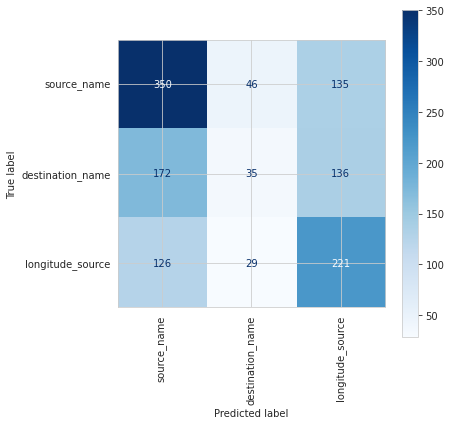

              precision    recall  f1-score   support

           1      0.540     0.659     0.594       531
           2      0.318     0.102     0.155       343
           3      0.449     0.588     0.509       376

    accuracy                          0.485      1250
   macro avg      0.436     0.450     0.419      1250
weighted avg      0.452     0.485     0.448      1250



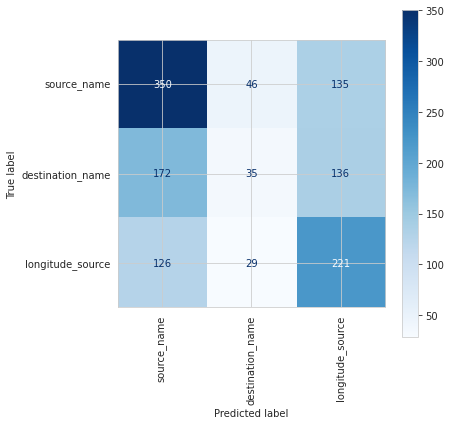

              precision    recall  f1-score   support

           1      0.540     0.659     0.594       531
           2      0.318     0.102     0.155       343
           3      0.449     0.588     0.509       376

    accuracy                          0.485      1250
   macro avg      0.436     0.450     0.419      1250
weighted avg      0.452     0.485     0.448      1250



In [236]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train,y_train)
predictProba(lr, X_train)
predictProba(lr, X_train, dev=True)

In [237]:
import eli5
from eli5.sklearn import PermutationImportance

In [239]:
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Feature Importances using Permutation Importance


Weight,Feature
0.0224 ± 0.0096,sin_date
0.0120 ± 0.0042,mean_halt_times_source
0.0117 ± 0.0048,cos_date
0.0107 ± 0.0119,cos_day
0.0096 ± 0.0112,sin_day
0.0056 ± 0.0076,destination_name
0.0045 ± 0.0073,cos_time
0.0037 ± 0.0075,mean_halt_times_destination
0.0032 ± 0.0099,cos_week
0.0029 ± 0.0037,longitude_destination


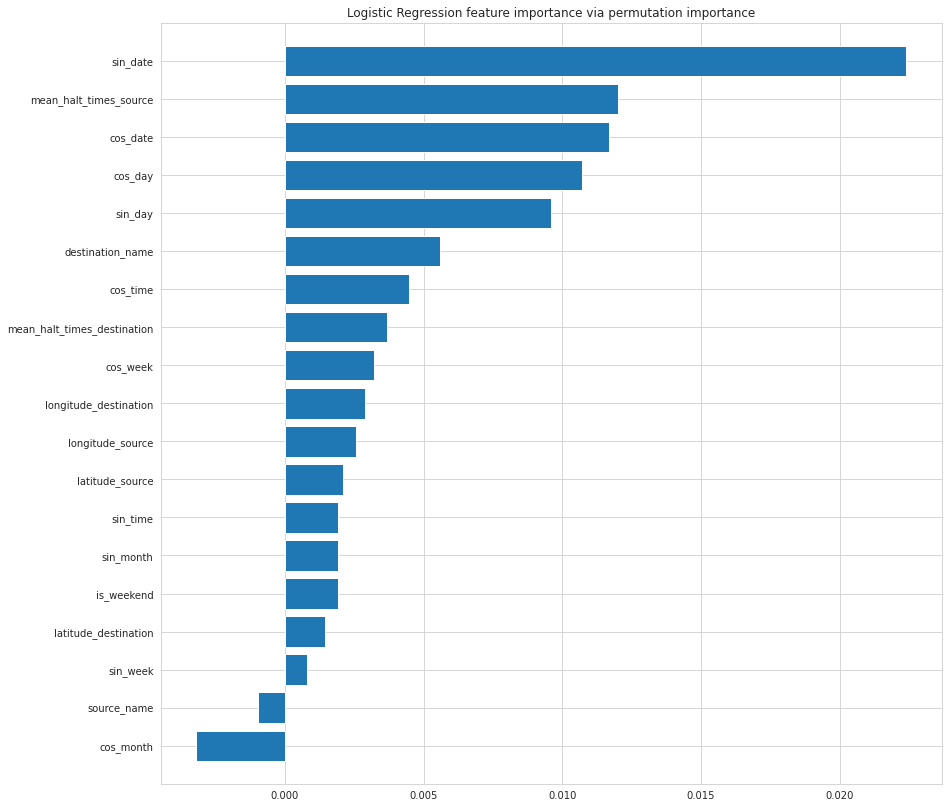

In [240]:
# plot the permutation importances
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_test.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(X_test.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(X_test.shape[1]), perm_features)
plt.ylim([X_test.shape[1], -1])
plt.show()

In [259]:
# build model using perm selected top 12 features
X_train_perm = X_train[perm_features[:12]]
X_train_rfe = X_train_perm

###XGBoost

In [274]:
import xgboost as xgb
xgbc = xgb.XGBClassifier(n_estimators=100, random_state=seed)
xgbc.fit(X_train_rfe, y_train)
y_pred = xgbc.predict(X_test[perm_features[:12]])
predictions = list(y_pred)

In [265]:
df3 = pd.read_csv('test.csv')
df4 = pd.DataFrame()

In [267]:
df3['id_code']

0      mckbezdplrukagl
1      agxwrnbmzbyxsjg
2      iqjojyewdyfshtj
3      hssqexnzirioaag
4      lublknpfraiznhr
            ...       
959    pnfrvyxsejnehwu
960    omsilbnrgbvkeak
961    vkjvqmaaguaeqde
962    iutnjhogthfpymb
963    xwqxedeqlnimclu
Name: id_code, Length: 964, dtype: object

In [272]:
df4['id_code'] = df3['id_code']
df4['target'] = y_pred

map_rev = {1:'low', 2:'medium', 3:'high'}

In [276]:
df4 = df4.replace({'target':map_rev})

In [278]:
df4.to_csv('submission_final.csv')